In [1]:
# import time
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
from IPython.display import Audio, display
#from pydub import AudioSegment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import os.path
from os import path
import os
import soundfile as sf
# import torchaudio.functional as F
# import torchaudio.transforms as T
import librosa
from tqdm.notebook import tqdm
from pytorch_pretrained_vit import ViT

from torchaudio import transforms
from torchvision import transforms as T
import torchvision.models as models
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torchaudio.__version__)

C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


1.8.1
0.8.1


In [2]:
!nvidia-smi 

Sun Apr 04 12:56:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P5    12W /  N/A |    605MiB /  6144MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

# panda time

In [3]:
tracks = pd.read_csv('data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
subset=tracks.index[tracks['set', 'subset'] == 'small']
tracks=tracks.loc[subset]
tracks;

## split dataset (train, test)

In [4]:
# train => track_id train 
# data => track_id + label
train_index = tracks.index[tracks['set', 'split'] == 'training']
val_index = tracks.index[tracks['set', 'split'] == 'validation']
test_index = tracks.index[(tracks['set', 'split'] == 'test' )| (tracks['set', 'split']=='validation') ]
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train_index, val_index, test_index])))
genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
print('Top genres ({}): {}'.format(len(genres), genres))
data=tracks['track', 'genre_top']
# data,train_index[0], data.loc[train_index[0]] # (2, 'Hip-Hop')

6400 training examples, 800 validation examples, 1600 testing examples
Top genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']


In [5]:
enc = MultiLabelBinarizer()
labels = tracks['track', 'genres_all']
#labels = tracks['track', 'genres']
test_multi_index = tracks.index[(tracks['set', 'split'] == 'test' ) ]

# Split in training, validation and testing sets.
y_train = enc.fit_transform(labels[train_index])
y_val = enc.transform(labels[val_index])
y_test = enc.transform(labels[test_index])
# X_train = features.loc[train, columns].as_matrix()
# X_val = features.loc[val, columns].as_matrix()
# X_test = features.loc[test, columns].as_matrix()

/!\ data corrupted delete them : "099134.mp3" "108925.mp3" "133297.mp3" use cell below

In [6]:
#beug fix that
flag=len(train_index)
for i in range(len(train_index)):
    if flag==i:
        break
    if str(train_index[i])=="99134" or str(train_index[i])=="108925" or str(train_index[i])=="133297":
        print(i)
        train_index=train_index.delete(i)
        y_train=np.delete(y_train, i,axis=0)

        flag=flag-1


3530
3896
5609


## (use one time) to convert all mp3 to wav (more than 10 to 100 times faster with wav)

#!mkdir "data_proces/fma_small/"
path1="data/fma_small/"
path_stockage="data_proces/fma_small/"
count=0
for root, dirs, files in os.walk(path1):
    for name in files:
        if name.endswith(".mp3"):
            if not(path.exists(path_stockage+name[:-4]+'.wav')):
                try:
                    waveform, sample_rate=librosa.load(root+"/"+name,duration=15,sr=22050)
                    sf.write(path_stockage+name[:-4]+'.wav', waveform, sample_rate)
                    count+=1
                except:
                    print("audio :"+root+"/"+name+"  is corrupted")

# creation of dataset and dataloader

In [7]:
from torch.utils.data import Dataset, DataLoader

# creation of torch dataset


#type_set= train or test 
#audio_ids
label_dic = {'Electronic': 0,  'Experimental':1, 'Folk':2,'Hip-Hop':3,
 'Instrumental':4,
 'International':5,
 'Pop':6,
 'Rock':7}


class Audio_classification(Dataset):
    def __init__(self,type_set, audio_idx, class_ids,label_dic,time_audio_resize=3, transform = None):#("train",train,data,)
            self.type_set=type_set
            self.audio_ids = audio_idx
            self.class_ids = class_ids
            self.label_dic = label_dic
            self.time_audio_resize=time_audio_resize
            self.transform = transform
#             if self.is_valid == 1:
#                 self.aug = # transfoms for validation images
#             else:                  
#                 self.aug = # transfoms for training images
                
    def __len__(self):
          return len(self.audio_ids)
    
        
    def __getitem__(self, index):
            #on prend 3s
            load_first_n_sec_audio=15
            sample_rate_default=22050
            #time_audio_resize #= 3#sec
            
            #audio_path is like 000002.wav but self.audio_ids[index] has not all the 0 include so ...
            idx=self.audio_ids[index]
            count=len(str(idx))
            #print("The number of digits in the number are:",count)
            if count!=6:
                idx="0"*(6-count)+str(idx)
            audio_path=str(idx)

            filename = "data_proces/fma_small/"+ audio_path +".wav"
            label = self.label_dic[self.class_ids.loc[self.audio_ids[index]]]
            
            #load audio mp3
            
            waveform, sample_rate=torchaudio.load(filename, normalize = True)
            #waveform, sample_rate=sf.read(filename,sr=None)
                
            len_audio_resize = int(sample_rate_default * self.time_audio_resize)
            indice_max=len(waveform[0])-len_audio_resize-1
            indice_initial=np.random.randint(max(indice_max,1))
            #make 3sec long audio (time_audio_resize=3sec)
            if self.type_set=="train":
                waveform = waveform[:,indice_initial:indice_initial+len_audio_resize]
            else:
                waveform = waveform[:,0:len_audio_resize]
                
            # if weveform is to short zero padding at the end 
            if waveform.size()!=(1,len_audio_resize):
                waveform=torch.cat((waveform,torch.zeros((1,len_audio_resize-waveform.size(1)))),1)
            #to torch
            #waveform=torch.tensor(waveform)#m, dtype = torch.float)
            # reshape to 1 channel if required
            #waveform = torch.reshape(waveform, (1, waveform.shape[0]))
           # Change the waveform to Spectrogram, Mel-Spectrogram or,MFCC
#             specgram = torchaudio.transforms.Spectrogram()(waveform)

#             # convert 1 channel to 3 channels applying imagenet models
#             specgram = specgram.repeat(3, 1, 1)

#             # Applying audio augmentations by converting to numpy array
#             specgram = np.transpose(specgram.numpy(), (1,2,0))
#             specgram = self.aug(image = specgram)['image']

#             #As torch accepts channels first so applying this
#             specgram = np.transpose(specgram,(2,0,1)).astype(np.float32)
#             specgram=torch.tensor(waveform, dtype = torch.float) 
            if self.transform:
                waveform = self.transform(waveform)
            return waveform,torch.tensor(label, dtype = torch.float)
#             return {
#                 'waveform' : waveform,
#                 'label' : torch.tensor(label, dtype = torch.float)
#             }
        


In [8]:

def init_param(model,device=device):
    if model.image_size==(384,384):
        print("384")
        trainset  = Audio_classification("train",train_index,data,label_dic,time_audio_resize=8.9)
        trainloader  = DataLoader(trainset , batch_size=5,
                                shuffle=True, num_workers=0)

        testset = Audio_classification("test",test_index,data,label_dic,time_audio_resize=8.9)
        testloader   = DataLoader(testset , batch_size=5,
                            shuffle=False, num_workers=0)

        sample_rate=22050
        n_fft = 2048
        win_length = None
        hop_length = 512
        n_mels = 512
        n_mfcc = 384
        log_mels=True
        mfcc_transform = transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,log_mels=log_mels, melkwargs={'n_fft': n_fft, 'n_mels': n_mels, 'hop_length': hop_length})


        n_fft = 2048
        win_length = None
        hop_length = 512
        n_mels = 384#128
        sample_rate=22050
        mel_spectrogram = transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm='slaney',
            onesided=True,
            n_mels=n_mels,
        )


        n_fft = 766
        win_length = None
        hop_length = 512

        # define transformation
        spectrogram = transforms.Spectrogram(
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            normalized=True #a test
        )

        normalize_spec_db = T.Normalize(mean=[-15.0580, -63.8859, -43.7740],
                            std=[19.4417, 48.3987, 21.0964])


    if model.image_size==(224,224):
        print("224")
        


        trainset  = Audio_classification("train",train_index,data,label_dic,time_audio_resize=5.2)
        trainloader  = DataLoader(trainset , batch_size=64,
                                shuffle=True, num_workers=0)

        testset = Audio_classification("test",test_index,data,label_dic,time_audio_resize=5.2)
        testloader   = DataLoader(testset , batch_size=64,
                                shuffle=False, num_workers=0)
        sample_rate=22050
        n_fft = 2048
        win_length = None
        hop_length = 512
        n_mels = 256
        n_mfcc = 224
        log_mels=True
        mfcc_transform = transforms.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,log_mels=log_mels, melkwargs={'n_fft': n_fft, 'n_mels': n_mels, 'hop_length': hop_length})

        # mfcc = mfcc_transform(waveform)
        # plot_spectrogram(mfcc[0])

        n_fft = 2048
        win_length = None
        hop_length = 512
        n_mels = 224#128
        sample_rate=22050
        mel_spectrogram = transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
            norm='slaney',
            onesided=True,
            n_mels=n_mels,
        )


        n_fft = 446
        win_length = None
        hop_length = 512

        # define transformation
        spectrogram = transforms.Spectrogram(
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            center=True,
            pad_mode="reflect",
            power=2.0,
        )
        normalize_spec_db = T.Normalize(mean=[-13.8637, -53.9947, -21.2606],
                            std=[19.2690, 49.1503, 22.0783])
    
    all_spectro=[mel_spectrogram.to(device),mfcc_transform.to(device),spectrogram.to(device)]

    return normalize_spec_db, all_spectro, trainloader, testloader
    # a=iter(trainloader)
    # im,l=next(a)
    # size_in=im.size(2)
    # aa=mel_spectrogram(im)
    # bb=spectrogram(im)
    # aa.size(),bb.size()

# train and test function

# with spectro

## import and create mel mfcc spectrogramm

## train/test loader

## calcul normalisation parameters mean/std

## plot spec

In [9]:

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)#librosa.power_to_db(spec)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

# transformer
https://colab.research.google.com/drive/1muZ4QFgVfwALgqmrfOkp7trAvqDemckO?usp=sharing#scrollTo=sb13T_M0yFb1
https://colab.research.google.com/github/ra1ph2/Vision-Transformer/blob/main/VisionTransformer.ipynb

In [10]:
#!pip install --upgrade pytorch-pretrained-vit

In [11]:
from pytorch_pretrained_vit import ViT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchaudio import transforms
from torchvision import transforms as T
import torchvision.models as models
from torchsummary import summary
from pytorch_pretrained_vit.configs import PRETRAINED_MODELS


In [12]:
#train test  function

#https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html
use_amp = False #mixed precision float 16
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def train_transf(transformer,model, device, trainloader, criterion, optimizer, epoch,scheduler,all_spectro,transform_train_db, log_interval,grad_clip=None,Use_waveform=True):
    model.train()
    correct = 0
    train_loss = 0
    use_waveform=Use_waveform
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            spec=torch.tensor([]).to(device)
            if use_waveform:#use waveform only
                #all_spectro=all_spectro[1:]
#                 wave=data[:,:,:transformer.image_size[0]**2]
#                 data=wave.view(wave.size(0),1,transformer.image_size[0],transformer.image_size[0]).repeat(1,3,1,1)
                im=data
                size_in=im.size(2)
                zero_pad=torch.zeros(im.size(0),1,transformer.image_size[0]**2*3-size_in).to(device)
                concat=torch.cat((zero_pad,im),2).view(im.size(0),3,transformer.image_size[0],transformer.image_size[0])
                data=concat
            else:
                for spectro in all_spectro :
                    spec1=spectro(data)
                    spec=torch.cat((spec,spec1),1)
                spec=spec.to(device)
                spec=transform_train_db(spec)
                #data=torch.cat((spec,data[:,:transformer.image_size[0]**2]),1)
            transf_out = transformer(data).squeeze(0)#.repeat(1,3, 1, 1)
        with torch.cuda.amp.autocast(enabled=use_amp): # full mixed precision enabled=use_amp   
            output = model(transf_out)
            loss = criterion(output, target.long())
        scaler.scale(loss).backward()
        if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
#         loss.backward()
#         optimizer.step()
        train_loss += loss.item()
#     if batch_idx % log_interval == 0:
    print('Train Epoch: {}  \tLoss: {:.6f}   Accuracy: {}/{} ({:.0f}%'.format(
        epoch, loss.item(), correct, len(trainloader.dataset), 100. * correct / len(trainloader.dataset)))
    return train_loss/len(trainloader.dataset),100. * correct / len(trainloader.dataset)


def test_transf(transformer,model, device, testloader,criterion,all_spectro,transform_test_db,Use_waveform=True):
    use_waveform=Use_waveform
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            if use_waveform:#use waveform only
                #all_spectro=all_spectro[1:]
#                 wave=data[:,:,:transformer.image_size[0]**2]
#                 data=wave.view(wave.size(0),1,transformer.image_size[0],transformer.image_size[0]).repeat(1,3,1,1)
                im=data
                size_in=im.size(2)
                zero_pad=torch.zeros(im.size(0),1,transformer.image_size[0]**2*3-size_in).to(device)
                concat=torch.cat((zero_pad,im),2).view(im.size(0),3,transformer.image_size[0],transformer.image_size[0])
                data=concat
            else:
                spec=torch.tensor([]).to(device)
                for spectro in all_spectro :
                    spec1=spectro(data)
                    spec=torch.cat((spec,spec1),1)
                data=spec.to(device)
                data=transform_test_db(data)
            transf_out = transformer(data).squeeze(0)
            output = model(transf_out)
            test_loss += criterion(output, target.long()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return test_loss,100. * correct / len(testloader.dataset)

In [13]:

# trans=[mel_spectrogram,mfcc_transform,spectrogram]
# amp_db=transforms.AmplitudeToDB()
# db=True
# means=[[],[],[]]
# stds=[[],[],[]]
# for batch_idx, (im, target) in enumerate(tqdm(trainloader)):
#     for i in range(len(trans)):
#         if db:
#             means[i].append(torch.mean(amp_db(trans[i](im))))
#             stds[i].append(torch.std(amp_db(trans[i](im))))

#         else:
#             means[i].append(torch.mean(trans[i](im)))
#             stds[i].append(torch.std(trans[i](im)))

# mean = torch.mean(torch.tensor(means),1)
# std = torch.mean(torch.tensor(stds),1)
# print(mean,std)


In [12]:
#Pretrained on ImageNet-21k and fine tune on ImageNet-1k
model_name = 'B_16_imagenet1k' #86859496
model_name = "B_32_imagenet1k" #88297192
model_name = "B_32_imagenet1k" #88297192
model_name ="L_16_imagenet1k" #304 715 752
model_name ="L_32_imagenet1k" #306 632 680
# just Pretrained on ImageNet-21k
model_name ="L_32" #327 899 475
model_name ="B_16" #102 595 923
model_name ="B_32" #104 252 499
model_name ="L_16" # pretraine param not avaiable
model_name ="L_32" #327 899 475
# count_parameters(model)

In [14]:

model_name ="L_16_imagenet1k"# 'B_16_imagenet1k'

model = ViT(model_name, pretrained=True).to(device)
model.fc=nn.Identity()

model.image_size

Loaded pretrained weights.


(384, 384)

In [14]:
model

ViT(
  (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_k): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_v): Linear(in_features=1024, out_features=1024, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      

In [15]:
amp_db=transforms.AmplitudeToDB().to(device)

# index = 1
   
normalize_spec_db, all_spectro, trainloader, testloader=init_param(model)
use_wave=False
if use_wave==True:

    trainset  = Audio_classification("train",train_index,data,label_dic,time_audio_resize=15)
    trainloader  = DataLoader(trainset , batch_size=4,
                            shuffle=True, num_workers=0)

    testset = Audio_classification("test",test_index,data,label_dic,time_audio_resize=15)
    testloader   = DataLoader(testset , batch_size=4,
                        shuffle=False, num_workers=0)

transform_train_db = T.Compose([  amp_db,     
                                
        normalize_spec_db,
         # transforms.TimeStretch(fixed_rate =1.2),
        #transforms.TimeMasking(time_mask_param=20),
        #transforms.FrequencyMasking(freq_mask_param=30),
        #T.RandomHorizontalFlip(),
        #T.Resize((image_size,image_size))
                       ])
transform_test_db = T.Compose([amp_db,           
        normalize_spec_db])


384


C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\functional\functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "
C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\functional\functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (384) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


In [16]:
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
    def forward(self, input):
        return input * torch.tanh(F.softplus(input))

In [17]:
model=model.to(device)

In [18]:
torch.cuda.empty_cache()
criterion = nn.CrossEntropyLoss()
grad_clip = 0.2
weight_decay = 1e-6
#post_transf=nn.Sequential(nn.Linear(21843,512),nn.ReLU(),nn.Linear(512,8)).to(device)
# TRY
# post_transf=nn.Sequential(nn.Linear(768,512),nn.ReLU(),nn.Linear(512,8)).to(device)
post_transf=nn.Sequential(nn.Linear(1024,1024),Mish(),nn.Linear(1024,1024),Mish(),nn.Linear(1024,8)).to(device)

optimizer = optim.Adam(post_transf.parameters(), lr=0.001,weight_decay=0)
Train_loss=[]
Test_loss=[]
Train_correct=[]
Test_correct=[]


  0%|          | 0/1280 [00:00<?, ?it/s]

Train Epoch: 1  	Loss: 2.040901   Accuracy: 2747/6397 (43%

Test set: Average loss: 0.3471, Accuracy: 604/1600 (38%)

9.943280017715336e-11


  0%|          | 0/1280 [00:00<?, ?it/s]

Train Epoch: 2  	Loss: 1.239769   Accuracy: 2774/6397 (43%

Test set: Average loss: 0.3478, Accuracy: 571/1600 (36%)

4.6205439104398606e-11


  0%|          | 0/1280 [00:00<?, ?it/s]

Train Epoch: 3  	Loss: 0.865486   Accuracy: 2743/6397 (43%

Test set: Average loss: 0.3461, Accuracy: 593/1600 (37%)

4.341491138637447e-16


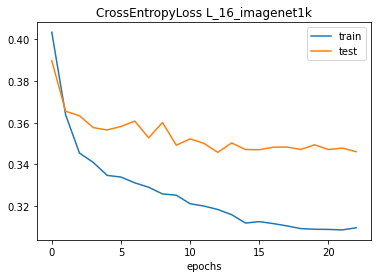

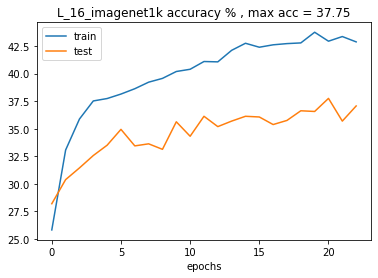

In [20]:


# model.res.classifier[2].p=0.0
# model.res.classifier[5].p=0.0
epochs=3
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-10, steps_per_epoch=len(trainloader), epochs=epochs)
for epoch in range(1, epochs + 1):
    train_loss,correct_train=train_transf(model,post_transf, device, trainloader, criterion, optimizer, epoch,scheduler,all_spectro,transform_train_db=transform_train_db,log_interval=100,grad_clip=grad_clip)
    test_loss,correct_test=test_transf(model,post_transf, device, testloader,criterion,all_spectro,transform_test_db)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Train_correct.append(correct_train)
    Test_correct.append(correct_test)
    print(optimizer.param_groups[0]['lr'])

plt.plot(Train_loss)
plt.plot(Test_loss)
plt.legend(["train","test"])
plt.title("CrossEntropyLoss "+model_name)
plt.xlabel("epochs")
plt.savefig('loss_'+model_name+' _spectro_all_spectr.png')
plt.show()

plt.plot(Train_correct)
plt.plot(Test_correct)
plt.legend(["train","test"])
plt.title(model_name+ " accuracy % , max acc = "+str(max(Test_correct)))
plt.xlabel("epochs")
plt.savefig('accuracy_ '+model_name+' _spectro_all_spectr.png')

In [ ]:
path="model_save/transformer_B_16_imagenet1k_classifier"+name_mod+".pth"
            torch.save(model.state_dict(), path)

TO TRY:
   - raw input in one or all layer 
   - every transformer layer
   - more complex feature extracter like spectrogram

# when you gpu suck (6 GB of vram ); )

In [9]:
from pytorch_pretrained_vit import ViT

"""model.py - Model and module class for ViT.
   They are built to mirror those in the official Jax implementation.
"""

from typing import Optional
import torch
from torch import nn
from torch.nn import functional as F

from pytorch_pretrained_vit.transformer import Transformer
from pytorch_pretrained_vit.utils import load_pretrained_weights, as_tuple
from pytorch_pretrained_vit.configs import PRETRAINED_MODELS


class PositionalEmbedding1D(nn.Module):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, seq_len, dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
    def forward(self, x):
        """Input has shape `(batch_size, seq_len, emb_dim)`"""
        return x + self.pos_embedding


class ViT(nn.Module):
    """
    Args:
        name (str): Model name, e.g. 'B_16'
        pretrained (bool): Load pretrained weights
        in_channels (int): Number of channels in input data
        num_classes (int): Number of classes, default 1000
    References:
        [1] https://openreview.net/forum?id=YicbFdNTTy
    """

    def __init__(
        self, 
        name: Optional[str] = None, 
        pretrained: bool = False, 
        patches: int = 16,
        dim: int = 768,
        ff_dim: int = 3072,
        num_heads: int = 12,
        num_layers: int = 12,
        attention_dropout_rate: float = 0.0,
        dropout_rate: float = 0.1,
        representation_size: Optional[int] = None,
        load_repr_layer: bool = False,
        classifier: str = 'token',
        positional_embedding: str = '1d',
        in_channels: int = 3, 
        image_size: Optional[int] = None,
        num_classes: Optional[int] = None,
    ):
        super().__init__()

        # Configuration
        if name is None:
            check_msg = 'must specify name of pretrained model'
            assert not pretrained, check_msg
            assert not resize_positional_embedding, check_msg
            if num_classes is None:
                num_classes = 1000
            if image_size is None:
                image_size = 384
        else:  # load pretrained model
            assert name in PRETRAINED_MODELS.keys(), \
                'name should be in: ' + ', '.join(PRETRAINED_MODELS.keys())
            config = PRETRAINED_MODELS[name]['config']
            patches = config['patches']
            dim = config['dim']
            ff_dim = config['ff_dim']
            num_heads = config['num_heads']
            num_layers = config['num_layers']
            attention_dropout_rate = config['attention_dropout_rate']
            dropout_rate = config['dropout_rate']
            representation_size = config['representation_size']
            classifier = config['classifier']
            if image_size is None:
                image_size = PRETRAINED_MODELS[name]['image_size']
            if num_classes is None:
                num_classes = PRETRAINED_MODELS[name]['num_classes']
        self.image_size = image_size                

        # Image and patch sizes
        h, w = as_tuple(image_size)  # image sizes
        fh, fw = as_tuple(patches)  # patch sizes
        gh, gw = h // fh, w // fw  # number of patches
        seq_len = gh * gw

        # Patch embedding
        self.patch_embedding = nn.Conv2d(in_channels, dim, kernel_size=(fh, fw), stride=(fh, fw))

        # Class token
        if classifier == 'token':
            self.class_token = nn.Parameter(torch.zeros(1, 1, dim))
            seq_len += 1
        
        # Positional embedding
        if positional_embedding.lower() == '1d':
            self.positional_embedding = PositionalEmbedding1D(seq_len, dim)
        else:
            raise NotImplementedError()
        
        # Transformer
        self.transformer = Transformer(num_layers=num_layers, dim=dim, num_heads=num_heads, 
                                       ff_dim=ff_dim, dropout=dropout_rate)
        
        # Representation layer
        if representation_size and load_repr_layer:
            self.pre_logits = nn.Linear(dim, representation_size)
            pre_logits_size = representation_size
        else:
            pre_logits_size = dim

        # Classifier head
        self.norm = nn.LayerNorm(pre_logits_size, eps=1e-6)
        self.fc = nn.Linear(pre_logits_size, num_classes)

        # Initialize weights
        self.init_weights()
        
        # Load pretrained model
        if pretrained:
            pretrained_num_channels = 3
            pretrained_num_classes = PRETRAINED_MODELS[name]['num_classes']
            pretrained_image_size = PRETRAINED_MODELS[name]['image_size']
            load_pretrained_weights(
                self, name, 
                load_first_conv=(in_channels == pretrained_num_channels),
                load_fc=(num_classes == pretrained_num_classes),
                load_repr_layer=load_repr_layer,
                resize_positional_embedding=(image_size != pretrained_image_size),
                strict=False
            )
        
    @torch.no_grad()
    def init_weights(self):
        def _init(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # _trunc_normal(m.weight, std=0.02)  # from .initialization import _trunc_normal
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.normal_(m.bias, std=1e-6)  # nn.init.constant(m.bias, 0)
        self.apply(_init)
        nn.init.constant_(self.fc.weight, 0)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.normal_(self.positional_embedding.pos_embedding, std=0.02)  # _trunc_normal(self.positional_embedding.pos_embedding, std=0.02)
        nn.init.constant_(self.class_token, 0)

    def forward(self, x):
        """Breaks image into patches, applies transformer, applies MLP head.
        Args:
            x (tensor): `b,c,fh,fw`
        """
        b, c, fh, fw = x.shape
        x = self.patch_embedding(x)  # b,d,gh,gw
        x = x.flatten(2).transpose(1, 2)  # b,gh*gw,d
        if hasattr(self, 'class_token'):
            x = torch.cat((self.class_token.expand(b, -1, -1), x), dim=1)  # b,gh*gw+1,d
        if hasattr(self, 'positional_embedding'): 
            x = self.positional_embedding(x)  # b,gh*gw+1,d 
        x = self.transformer(x)  # b,gh*gw+1,d
        if hasattr(self, 'pre_logits'):
            x = self.pre_logits(x)
            x = torch.tanh(x)
        if hasattr(self, 'fc'):
            x = self.norm(x)[:, 0]  # b,d
            x = self.fc(x)  # b,num_classes
        return x

In [10]:
class Little_ViT(nn.Module):
    def __init__(self,transformeur):
        super(Little_ViT, self).__init__()
        self.model=transformeur.to(device)
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.require_grad = True

        
    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.require_grad = True
        
    def forward(self, x):
        x=self.model(x)
        return x
    
# model=Res_Net_mix_spec([Net_res_mel(spectro_like_device,transform_train_db,transform_test_db).to(device),Net_res_mel(spectro_like_device,transform_train_db,transform_test_db).to(device)]).to(device)
# summary(model, ([1,size_in]))

In [11]:
#train test  function

#https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html
use_amp = False #mixed precision float 16
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def train_transf(model, device, trainloader, criterion, optimizer, epoch,scheduler,all_spectro,transform_train_db, log_interval,grad_clip=None,Use_waveform=True):
    model.train()
    correct = 0
    train_loss = 0
    use_waveform=Use_waveform
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            spec=torch.tensor([]).to(device)
            if use_waveform:#use waveform only
                #all_spectro=all_spectro[1:]
#                 wave=data[:,:,:transformer.image_size[0]**2]
#                 data=wave.view(wave.size(0),1,transformer.image_size[0],transformer.image_size[0]).repeat(1,3,1,1)
                im=data
                size_in=im.size(2)
                zero_pad=torch.zeros(im.size(0),1,model.image_size[0]**2*3-size_in).to(device)
                concat=torch.cat((zero_pad,im),2).view(im.size(0),3,model.image_size[0],model.image_size[0])
                data=concat
            else:
                for spectro in all_spectro :
                    spec1=spectro(data)
                    spec=torch.cat((spec,spec1),1)
                spec=spec.to(device)
                spec=transform_train_db(spec)
                data=spec.to(device)
                #data=torch.cat((spec,data[:,:transformer.image_size[0]**2]),1)
        with torch.cuda.amp.autocast(enabled=use_amp): # full mixed precision enabled=use_amp   
            output = model(data).squeeze(0)
            loss = criterion(output, target.long())
        scaler.scale(loss).backward()
        if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
#         loss.backward()
#         optimizer.step()
        train_loss += loss.item()
#     if batch_idx % log_interval == 0:
    print('Train Epoch: {}  \tLoss: {:.6f}   Accuracy: {}/{} ({:.0f}%'.format(
        epoch, loss.item(), correct, len(trainloader.dataset), 100. * correct / len(trainloader.dataset)))
    return train_loss/len(trainloader.dataset),100. * correct / len(trainloader.dataset)


def test_transf(model, device, testloader,criterion,all_spectro,transform_test_db,Use_waveform=True):
    use_waveform=Use_waveform
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            if use_waveform:#use waveform only
                #all_spectro=all_spectro[1:]
#                 wave=data[:,:,:transformer.image_size[0]**2]
#                 data=wave.view(wave.size(0),1,transformer.image_size[0],transformer.image_size[0]).repeat(1,3,1,1)
                im=data
                size_in=im.size(2)
                zero_pad=torch.zeros(im.size(0),1,model.image_size[0]**2*3-size_in).to(device)
                concat=torch.cat((zero_pad,im),2).view(im.size(0),3,model.image_size[0],model.image_size[0])
                data=concat
            else:
                spec=torch.tensor([]).to(device)
                for spectro in all_spectro :
                    spec1=spectro(data)
                    spec=torch.cat((spec,spec1),1)
                data=spec.to(device)
                data=transform_test_db(data)
            output = model(data.to(device)).squeeze(0)
            test_loss += criterion(output, target.long()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return test_loss,100. * correct / len(testloader.dataset)

In [15]:
torch.cuda.empty_cache()
criterion = nn.CrossEntropyLoss()
grad_clip = 0.2
weight_decay = 1e-6
#post_transf=nn.Sequential(nn.Linear(21843,512),nn.ReLU(),nn.Linear(512,8)).to(device)
# TRY
# post_transf=nn.Sequential(nn.Linear(768,512),nn.ReLU(),nn.Linear(512,8)).to(device)

PRETRAINED_MODELS["B_16_imagenet1k"]['config']['num_layers']=4
PRETRAINED_MODELS
model = ViT("B_16_imagenet1k", pretrained=False).to(device)
model.fc=nn.Linear(768, 512)#nn.Sequential(nn.Linear(768, 512),nn.ReLU(),nn.Linear(512, 8)).to(device)
little_ViT=Little_ViT(model).to(device)

optimizer = optim.Adam(little_ViT.parameters(), lr=0.001,weight_decay=0)
Train_loss=[]
Test_loss=[]
Train_correct=[]
Test_correct=[]


In [16]:
amp_db=transforms.AmplitudeToDB().to(device)

# index = 1
   
normalize_spec_db, all_spectro, trainloader, testloader=init_param(model)
use_wave=False
if use_wave==True:

    trainset  = Audio_classification("train",train_index,data,label_dic,time_audio_resize=15)
    trainloader  = DataLoader(trainset , batch_size=8,
                            shuffle=True, num_workers=0)

    testset = Audio_classification("test",test_index,data,label_dic,time_audio_resize=15)
    testloader   = DataLoader(testset , batch_size=8,
                        shuffle=False, num_workers=0)

transform_train_db = T.Compose([  amp_db,     
                                
        normalize_spec_db,
         # transforms.TimeStretch(fixed_rate =1.2),
        #transforms.TimeMasking(time_mask_param=20),
        #transforms.FrequencyMasking(freq_mask_param=30),
        #T.RandomHorizontalFlip(),
        #T.Resize((image_size,image_size))
                       ])
transform_test_db = T.Compose([amp_db,           
        normalize_spec_db])


384


C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\functional\functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "
C:\Users\lejuj\Anaconda3\envs\torchaudio\lib\site-packages\torchaudio\functional\functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (384) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


  0%|          | 0/800 [00:00<?, ?it/s]

Train Epoch: 1  	Loss: 7.062654   Accuracy: 815/6397 (13%

Test set: Average loss: 0.6010, Accuracy: 235/1600 (15%)

9.942752174436655e-10


  0%|          | 0/800 [00:00<?, ?it/s]

Train Epoch: 2  	Loss: 4.695582   Accuracy: 847/6397 (13%

Test set: Average loss: 0.5960, Accuracy: 235/1600 (15%)

4.617047889001959e-10


  0%|          | 0/800 [00:00<?, ?it/s]

Train Epoch: 3  	Loss: 4.313302   Accuracy: 851/6397 (13%

Test set: Average loss: 0.5957, Accuracy: 236/1600 (15%)

4.8742171597610385e-15


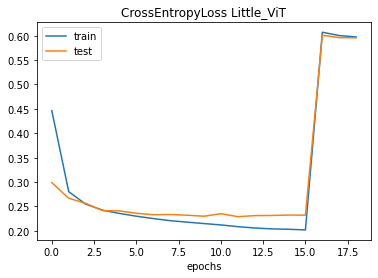

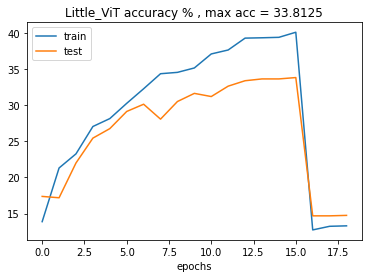

In [19]:
model_name="Little_ViT"


# model.res.classifier[2].p=0.0
# model.res.classifier[5].p=0.0
epochs=3
# little_ViT.freeze()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-9, steps_per_epoch=len(trainloader), epochs=epochs)
for epoch in range(1, epochs + 1):
    train_loss,correct_train=train_transf(model, device, trainloader, criterion, optimizer, epoch,scheduler,all_spectro,transform_train_db=transform_train_db,log_interval=100,grad_clip=grad_clip,Use_waveform=False)
    test_loss,correct_test=test_transf(model, device, testloader,criterion,all_spectro,transform_test_db,Use_waveform=False)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Train_correct.append(correct_train)
    Test_correct.append(correct_test)
    print(optimizer.param_groups[0]['lr'])

plt.plot(Train_loss)
plt.plot(Test_loss)
plt.legend(["train","test"])
plt.title("CrossEntropyLoss "+model_name)
plt.xlabel("epochs")
plt.savefig('loss_'+model_name+' _spectro_all_spectr.png')
plt.show()

plt.plot(Train_correct)
plt.plot(Test_correct)
plt.legend(["train","test"])
plt.title(model_name+ " accuracy % , max acc = "+str(max(Test_correct)))
plt.xlabel("epochs")
plt.savefig('accuracy_ '+model_name+' _spectro_all_spectr.png')

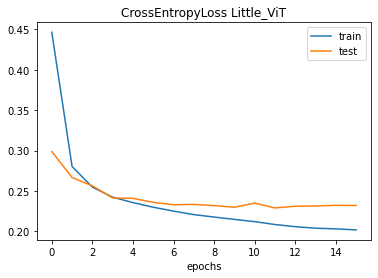

Text(0.5, 0, 'epochs')

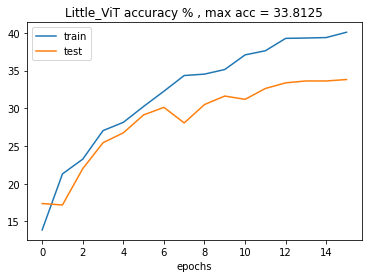

In [18]:
model_name="Little_ViT"
torch.save(the_model.state_dict(), PATH)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

# draft


In [136]:
import io
import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for line in train_iter:
    counter.update(tokenizer(line))
vocab = Vocab(counter)

def data_process(raw_text_iter):
  data = [torch.tensor([vocab[token] for token in tokenizer(item)],
                       dtype=torch.long) for item in raw_text_iter]
  return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\lejuj\ai\fma\fma\.data\wikitext-2-v1.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.48M/4.48M [00:06<00:00, 647kB/s]


In [140]:
def batchify(data, bsz):
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [141]:
train_data

tensor([[   10,    60,   565,  ..., 11653,  2436,     2],
        [ 3850,    13,   301,  ...,    48,    31,  1991],
        [ 3870,   316,    20,  ...,    98,  7721,     5],
        ...,
        [  588,  4012,    60,  ...,     2,  1440, 12314],
        [ 4988,    30,     5,  ...,  3166, 17107,  2061],
        [    7,     9,     2,  ...,    63,    19,     3]], device='cuda:0')

model.res.fc[2].p=0.0
model.res.fc[5].p=0.0
model.unfreeze

0 = mel
1 = mfcc
2 = spec
torch.cuda.empty_cache()

label_dic = {0: "model_save/resnet_conv1d mel db _specl.pth",  1:"model_save/resnet_conv1d mfcc db _specl.pth",2:"model_save/resnet_conv1d spec db_specl.pth"}

amp_db=transforms.AmplitudeToDB()
for i in range(4):
    if i==0:
        name_mod="conv1d mfcc+spec "
        index=[1,2]
    if i==1:
        name_mod="conv1d mfcc+mel "
        index=[0,1]
    if i==2:
        name_mod="conv1d mel+spec"
        index=[0,2]
    if i==3:
        name_mod="conv1d mfcc+mel+spec"
        index=[0,1,2]
    
    all_model=[]
    
    for j in range(len(index)):
        idx=index[j]
        spectro_like=[mel_spectrogram,mfcc_transform,spectrogram]
        spectro_like=[spectro_like[idx]]
        spectro_like_device=[i.to(device) for i in spectro_like]


        normalize_spec_db = T.Normalize(mean=[[-13.8637, -53.9947, -21.2606][idx]],
                                std=[[19.2690, 49.1503, 22.0783][idx]])

        transform_train_db = T.Compose([ amp_db,           
                normalize_spec_db,
                transforms.TimeMasking(time_mask_param=20),
                #transforms.FrequencyMasking(freq_mask_param=30),
                #T.RandomHorizontalFlip(),
                #T.Resize((image_size,image_size))
                               ])
        transform_test_db = T.Compose([ amp_db,           
                normalize_spec_db])


        all_model.append(Net_res_mel(spectro_like_device,transform_train_db,transform_test_db).to(device))
        
        all_model[j].load_state_dict(torch.load(label_dic[idx]))#,strict=False)
        all_model[j].fc[6],all_model[j].fc[5]=nn.Identity(),nn.Identity()
    
    model=Res_Net_mix_spec(all_model).to(device)
    criterion = nn.CrossEntropyLoss()
    grad_clip = 0.1
    weight_decay = 1e-5
    optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=weight_decay)
    Train_loss=[]
    Test_loss=[]
    Train_correct=[]
    Test_correct=[]
    best_model=40
    epochs1=6
    epochs2=6
    epochs=epochs1+epochs2
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-5, steps_per_epoch=len(trainloader), epochs=epochs1+1)
    model.freeze()
    
    for epoch in range(1, epochs + 1):
        if epoch==epochs1:
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-5, steps_per_epoch=len(trainloader), epochs=epochs2+1)
            model.unfreeze()
        train_loss,correct_train=train(model, device, trainloader, criterion, optimizer, epoch,scheduler,log_interval=100,grad_clip=grad_clip)
        test_loss,correct_test=test(model, device, testloader,criterion)
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Train_correct.append(correct_train)
        Test_correct.append(correct_test)
        print(optimizer.param_groups[0]['lr'])
        #save model
        if correct_test>best_model:
            best_model=correct_test
            path="model_save/resnet_"+name_mod+"_specl.pth"
            torch.save(model.state_dict(), path)
        
    plt.plot(Train_loss)
    plt.plot(Test_loss)
    plt.legend(["train","test"])
    plt.title("CrossEntropyLoss "+name_mod)
    plt.xlabel("epochs")
    plt.savefig('loss_'+name_mod+' _spectro_all_spectr.png')
    plt.show()

    plt.plot(Train_correct)
    plt.plot(Test_correct)
    plt.legend(["train","test"])
    plt.title(name_mod+ " accuracy % , max acc = "+str(max(Test_correct)))
    plt.xlabel("epochs")
    plt.savefig('accuracy_ '+name_mod+' _spectro_all_spectr.png')


    plt.show()

model.res.fc[2].p=0.0
model.res.fc[5].p=0.0
#model.unfreeze
amp_db=transforms.AmplitudeToDB()
architecture_name="dense net"
#architecture_name="conv1d" #pour resnet 

for i in range(3):
    if i==0:
        name_mod=architecture_name+" mel db "
    if i==1:
        name_mod=architecture_name+" mfcc db "
    if i==2:
        name_mod=architecture_name+" spec db"
    index = i
    
    spectro_like=[mel_spectrogram,mfcc_transform,spectrogram]
    spectro_like=[spectro_like[index]]
    spectro_like_device=[i.to(device) for i in spectro_like]

    normalize_spec = T.Normalize(mean=[[12.6111, -0.0646,  7.8345][index]],
                            std=[[138.5886,   4.2762, 112.3290][index]])
    normalize_spec_db = T.Normalize(mean=[[-13.8637, -53.9947, -21.2606][index]],
                            std=[[19.2690, 49.1503, 22.0783][index]])
    transform_train = T.Compose([             
           # transforms.TimeStretch(fixed_rate =1.2),
            normalize_spec,
            transforms.TimeMasking(time_mask_param=20),
            #transforms.FrequencyMasking(freq_mask_param=30),
            #T.RandomHorizontalFlip(),
            #T.Resize((image_size,image_size))
                           ])
    transform_test = T.Compose([       
            normalize_spec ])

    transform_train_db = T.Compose([  amp_db,           
            normalize_spec_db,
            transforms.TimeMasking(time_mask_param=20),
            #transforms.FrequencyMasking(freq_mask_param=30),
            #T.RandomHorizontalFlip(),
            #T.Resize((image_size,image_size))
                           ])
    transform_test_db = T.Compose([ amp_db,           
            normalize_spec_db])
    
    torch.cuda.empty_cache()
    criterion = nn.CrossEntropyLoss()
    grad_clip = 0.1
    weight_decay = 1e-5
    model=Net_res_mel(spectro_like_device,transform_train_db,transform_test_db).to(device)# transform_train,transform_test 
    optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=weight_decay)
    Train_loss=[]
    Test_loss=[]
    Train_correct=[]
    Test_correct=[]
    best_model=35
    epochs=30
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.8e-4, steps_per_epoch=len(trainloader), epochs=epochs)
    for epoch in range(1, epochs + 1):
        train_loss,correct_train=train(model, device, trainloader, criterion, optimizer, epoch,scheduler,log_interval=100,grad_clip=grad_clip)
        test_loss,correct_test=test(model, device, testloader,criterion)
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Train_correct.append(correct_train)
        Test_correct.append(correct_test)
        print(optimizer.param_groups[0]['lr'])
        #save model
        if correct_test>best_model:
            best_model=correct_test
            path="model_save/resnet_"+name_mod+"_specl.pth"
            torch.save(model.state_dict(), path)
        
    plt.plot(Train_loss)
    plt.plot(Test_loss)
    plt.legend(["train","test"])
    plt.title("CrossEntropyLoss "+name_mod)
    plt.xlabel("epochs")
    plt.savefig('loss_'+name_mod+' _spectro_all_spectr.png')
    plt.show()

    plt.plot(Train_correct)
    plt.plot(Test_correct)
    plt.legend(["train","test"])
    plt.title(name_mod+ " accuracy % , max acc = "+str(max(Test_correct)))
    plt.xlabel("epochs")
    plt.savefig('accuracy_ '+name_mod+' _spectro_all_spectr.png')


    plt.show()